In [ ]:
import os, gc, json, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 120)
plt.rcParams["figure.figsize"] = (8,5)

In [ ]:
PATH = "Taxi_Trips.csv"

df = pd.read_csv(PATH, nrows=None, low_memory=False)

RENAME = {
    "Trip Start Timestamp": "start_ts",
    "Trip End Timestamp": "end_ts",
    "Trip Seconds": "mins",
    "Trip Miles": "miles",
    "Pickup Community Area": "pickup_ca",
    "Dropoff Community Area": "dropoff_ca",
    "Fare": "fare",
    "Tips": "tips",
    "Tolls": "tolls",
    "Extras": "extras",
    "Trip Total": "total",
    "Payment Type": "payment",
    "Company": "company",
    "Pickup Centroid Latitude": "pickup_ct_lat",
    "Pickup Centroid Longitude": "pickup_ct_lon",
    "Dropoff Centroid Latitude": "dropoff_ct_lat",
    "Dropoff Centroid Longitude": "dropoff_ct_lon",
}
df = df.rename(columns=RENAME)

In [ ]:
df.isna().mean()

Trip ID                       0.000000
Taxi ID                       0.000001
start_ts                      0.000000
end_ts                        0.000009
mins                          0.000195
miles                         0.000007
Pickup Census Tract           0.621783
Dropoff Census Tract          0.637267
pickup_ca                     0.026807
dropoff_ca                    0.096912
fare                          0.002363
tips                          0.002363
tolls                         0.002363
extras                        0.002363
total                         0.002363
payment                       0.000000
company                       0.000000
pickup_ct_lat                 0.026543
pickup_ct_lon                 0.026543
Pickup Centroid Location      0.026543
dropoff_ct_lat                0.092084
dropoff_ct_lon                0.092084
Dropoff Centroid  Location    0.092084
dtype: float64

In [ ]:
import folium
from sklearn.cluster import KMeans
from shapely import wkt
import numpy as np
import pandas as pd

def process_location(df, col_name, prefix):
    """Process location column: clean, cluster, and create features"""
    # Remove NaN
    print(f"{prefix} - Original rows: {len(df)}")
    df = df.dropna(subset=[col_name])

    # Extract coordinates
    def get_coords(s):
        try:
            p = wkt.loads(s)
            return [p.x, p.y]
        except:
            return [np.nan, np.nan]

    coords = np.array(df[col_name].apply(get_coords).tolist())
    valid_mask = ~np.isnan(coords).any(axis=1)
    df = df[valid_mask].copy()
    coords = coords[valid_mask]

    print(f"{prefix} - Valid rows: {len(df)}")

    # Create clusters
    kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
    df[f'{prefix}_cluster'] = kmeans.fit_predict(coords)

    print(f"{prefix} - Created {df[f'{prefix}_cluster'].nunique()} clusters\n")
    return df, kmeans

def create_map(df, col_name, prefix, top_n=200):
    """Create interactive map"""
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

    for point_str, count in df[col_name].value_counts().head(top_n).items():
        point = wkt.loads(point_str)
        color = 'red' if count > 50000 else 'orange' if count > 10000 else 'blue'

        folium.CircleMarker(
            location=[point.y, point.x],
            radius=min(count/5000, 20),
            popup=f'{count:,} {prefix}s',
            color=color,
            fill=True,
            fillOpacity=0.7
        ).add_to(m)

    filename = f'chicago_{prefix}s.html'

# Process both locations
df, dropoff_kmeans = process_location(df, 'Dropoff Centroid  Location', 'dropoff')
df, pickup_kmeans = process_location(df, 'Pickup Centroid Location', 'pickup')
create_map(df, 'Dropoff Centroid  Location', 'dropoff')
create_map(df, 'Pickup Centroid Location', 'pickup')

dropoff - Original rows: 865247
dropoff - Valid rows: 785572


d:\anaconda\envs\mlops_env\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


dropoff - Created 20 clusters

pickup - Original rows: 785572
pickup - Valid rows: 779882
pickup - Created 20 clusters



<Axes: xlabel='pickup_cluster'>

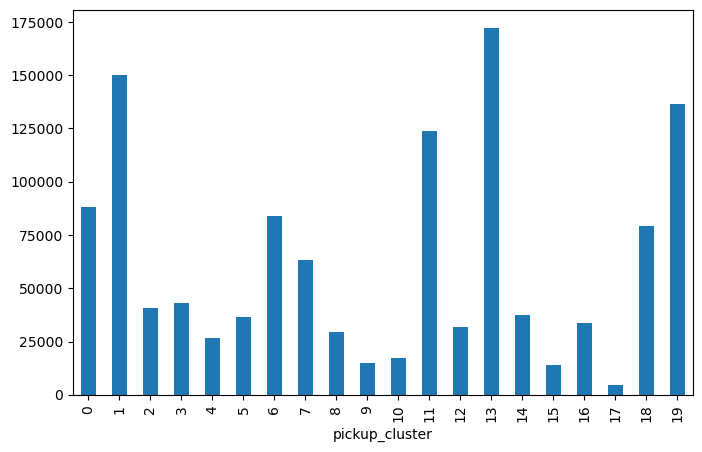

In [ ]:
df['dropoff_cluster'].value_counts().sort_index().plot.bar()
df['pickup_cluster'].value_counts().sort_index().plot.bar()

In [ ]:
for tcol in ["start_ts","end_ts"]:
    df[tcol] = pd.to_datetime(df[tcol], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

df["mins"] = df["mins"] / 60.0

for c in ["miles","mins","fare","tips","tolls","extras","total"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# NEW FEATURE: Euclidean distance between pickup and dropoff locations
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points on Earth in miles"""
    R = 3959  # Earth radius in miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["euclidean_distance"] = haversine_distance(
    df["pickup_ct_lat"], df["pickup_ct_lon"],
    df["dropoff_ct_lat"], df["dropoff_ct_lon"]
)

# Create distance ratio: how much longer is the actual trip vs straight-line distance
df["distance_ratio"] = np.where(
    (df["euclidean_distance"] > 0) & (df["miles"] > 0),
    df["miles"] / df["euclidean_distance"],
    np.nan
)

df["fare_per_mile"] = np.where((df["fare"].notna()) & (df["miles"]>0), df["fare"]/df["miles"], np.nan)
df["tip_rate"] = np.where((df["tips"].notna()) & (df["fare"]>0), df["tips"]/df["fare"], np.nan)
df["mph"] = df["miles"] / (df["mins"]/60.0)

df["date"] = df["start_ts"].dt.date
df["ymd"] = df["start_ts"].dt.to_period("D").astype(str)
df["dow"] = df["start_ts"].dt.dayofweek
df["hour"] = df["start_ts"].dt.hour
df["ts_hr"] = df["start_ts"].dt.floor("h")

df.describe()

d:\anaconda\envs\mlops_env\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,start_ts,end_ts,mins,miles,Pickup Census Tract,Dropoff Census Tract,pickup_ca,dropoff_ca,fare,tips,tolls,extras,total,pickup_ct_lat,pickup_ct_lon,dropoff_ct_lat,dropoff_ct_lon,dropoff_cluster,pickup_cluster,fare_per_mile,tip_rate,mph,dow,hour,ts_hr
count,779882,779882,779752.000000,779876.000000,3.125250e+05,3.125250e+05,779660.000000,775726.00000,778028.000000,778028.000000,778028.000000,778028.000000,778028.000000,779882.000000,779882.000000,779882.000000,779882.000000,779882.000000,779882.000000,701776.000000,776857.000000,7.676650e+05,779882.000000,779882.000000,779882
mean,2024-02-01 14:05:42.295245056,2024-02-01 14:24:25.690578944,18.470779,6.070591,1.703150e+10,1.703141e+10,34.635623,25.77553,20.620077,2.578647,0.050175,1.323114,24.745541,41.899279,-87.694532,41.892153,-87.659297,7.975139,9.933535,12.109958,0.142437,inf,2.684361,13.735029,2024-02-01 13:43:10.379569664
min,2024-01-01 00:00:00,2024-01-01 00:00:00,0.000000,0.000000,1.703101e+10,1.703101e+10,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,41.660136,-87.913625,41.650222,-87.913625,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,2024-01-01 00:00:00
25%,2024-01-18 14:15:00,2024-01-18 14:30:00,7.366667,0.900000,1.703108e+10,1.703108e+10,8.000000,8.00000,7.750000,0.000000,0.000000,0.000000,9.750000,41.878866,-87.708366,41.878866,-87.663518,2.000000,3.000000,2.658432,0.000000,8.400000e+00,1.000000,10.000000,2024-01-18 14:00:00
50%,2024-02-01 14:15:00,2024-02-01 14:30:00,14.100000,2.630000,1.703132e+10,1.703132e+10,32.000000,28.00000,13.750000,0.070000,0.000000,0.000000,16.500000,41.895033,-87.642498,41.892508,-87.633308,7.000000,11.000000,3.664495,0.010769,1.327374e+01,3.000000,14.000000,2024-02-01 14:00:00
75%,2024-02-16 12:30:00,2024-02-16 12:45:00,25.733333,11.210000,1.703198e+10,1.703184e+10,56.000000,32.00000,32.000000,3.650000,0.000000,1.000000,35.750000,41.965812,-87.625192,41.922686,-87.625192,13.000000,18.000000,6.081081,0.230986,2.554054e+01,4.000000,18.000000,2024-02-16 12:00:00
max,2024-03-01 00:00:00,2024-03-01 14:30:00,1439.000000,3093.470000,1.703198e+10,1.703198e+10,77.000000,77.00000,9999.750000,200.000000,4444.440000,5051.100000,9999.750000,42.021224,-87.534903,42.021224,-87.534903,19.000000,19.000000,100000.000000,910.000000,inf,6.000000,23.000000,2024-03-01 00:00:00
std,NaN,NaN,24.361131,7.554635,3.677273e+05,3.390069e+05,25.564095,20.43807,23.590175,3.743754,13.597918,18.780736,39.591547,0.064502,0.109175,0.059224,0.067579,5.417194,6.877684,169.225200,1.423271,NaN,1.841246,5.048129,NaN


In [ ]:
df = df[(df["miles"]>0) & (df["miles"]<200) & (df["mins"]>0) & (df["mins"]<600)]
df = df[(df["total"]>0) & (df["total"]<1000)]
df = df[(df["mph"] >= 5) & (df["mph"] <= 80)]

print(df.shape)
df.describe(percentiles=[.1,.5,.9,.95,.99])

(655463, 33)


,start_ts,end_ts,mins,miles,Pickup Census Tract,Dropoff Census Tract,pickup_ca,dropoff_ca,fare,tips,tolls,extras,total,pickup_ct_lat,pickup_ct_lon,dropoff_ct_lat,dropoff_ct_lon,dropoff_cluster,pickup_cluster,fare_per_mile,tip_rate,mph,dow,hour,ts_hr
count,655463,655463,655463.000000,655463.000000,2.618870e+05,2.618870e+05,655430.000000,651869.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655463.000000,655460.000000,655463.000000,655463.000000,655463.000000,655463
mean,2024-02-01 16:27:10.686095104,2024-02-01 16:46:05.770302464,18.892817,7.131897,1.703150e+10,1.703140e+10,34.999406,25.191683,21.162313,2.691909,0.003930,1.184499,25.239274,41.899959,-87.696099,41.891941,-87.656985,8.013078,10.015124,7.269049,0.143628,19.808005,2.675959,13.711996,2024-02-01 16:04:38.448669184
min,2024-01-01 00:00:00,2024-01-01 00:00:00,0.016667,0.010000,1.703101e+10,1.703101e+10,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.010000,41.660136,-87.913625,41.650222,-87.913625,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,2024-01-01 00:00:00
10%,2024-01-08 15:00:00,2024-01-08 15:30:00,5.000000,0.800000,1.703108e+10,1.703108e+10,8.000000,6.000000,5.750000,0.000000,0.000000,0.000000,7.000000,41.809084,-87.913625,41.812949,-87.711211,1.000000,0.000000,2.504174,0.000000,8.000000,0.000000,7.000000,2024-01-08 15:00:00
50%,2024-02-01 16:00:00,2024-02-01 16:30:00,15.083333,4.380000,1.703132e+10,1.703132e+10,32.000000,28.000000,15.000000,1.130000,0.000000,0.000000,17.500000,41.895033,-87.642498,41.892508,-87.633308,7.000000,11.000000,3.423913,0.114286,16.000000,3.000000,14.000000,2024-02-01 16:00:00
90%,2024-02-24 17:45:00,2024-02-24 18:00:00,37.466667,17.260000,1.703198e+10,1.703184e+10,76.000000,56.000000,43.500000,9.100000,0.000000,4.000000,55.250000,41.980264,-87.619711,41.975171,-87.618868,14.000000,19.000000,7.758621,0.320000,37.399293,5.000000,20.000000,2024-02-24 17:00:00
95%,2024-02-27 17:00:00,2024-02-27 17:15:00,45.450000,18.060000,1.703198e+10,1.703198e+10,76.000000,76.000000,45.750000,10.000000,0.000000,5.000000,59.400000,41.980264,-87.617358,41.982775,-87.615970,16.000000,19.000000,9.615385,0.413793,42.853879,6.000000,21.000000,2024-02-27 17:00:00
99%,2024-02-29 15:30:00,2024-02-29 15:45:00,61.616667,22.770000,1.703198e+10,1.703198e+10,77.000000,77.000000,60.500000,13.100000,0.000000,7.000000,72.500000,42.001571,-87.572782,42.005560,-87.572782,18.000000,19.000000,20.588235,0.666667,51.209370,6.000000,23.000000,2024-02-29 15:00:00
max,2024-03-01 00:00:00,2024-03-01 00:30:00,540.100000,135.570000,1.703198e+10,1.703198e+10,77.000000,77.000000,725.000000,200.000000,18.500000,300.000000,725.000000,42.021224,-87.534903,42.021224,-87.534903,19.000000,19.000000,22000.000000,910.000000,80.000000,6.000000,23.000000,2024-03-01 00:00:00
std,NaN,NaN,14.064800,6.543344,3.664798e+05,3.329976e+05,25.707183,19.952100,15.314208,3.718507,0.132361,2.367138,18.902407,0.064399,0.110849,0.058581,0.064067,5.430311,6.931609,93.706932,1.537683,11.678766,1.837490,5.012993,NaN


In [ ]:
hourly = (df.groupby("ts_hr")
         .agg(n_trips=("miles","size"),
              mean_fare_per_mile=("fare_per_mile","mean"),
              p90_fare_per_mile=("fare_per_mile", lambda x: np.nanpercentile(x,90)),
              mean_mph=("mph","mean"))
         .reset_index())

print(hourly.shape)
hourly

(1441, 5)


,ts_hr,n_trips,mean_fare_per_mile,p90_fare_per_mile,mean_mph
0,2024-01-01 00:00:00,282,48.080408,9.496970,19.613923
1,2024-01-01 01:00:00,367,27.521000,18.448905,15.517343
2,2024-01-01 02:00:00,330,102.867694,25.086207,17.350755
3,2024-01-01 03:00:00,171,10.745816,10.555556,18.222912
4,2024-01-01 04:00:00,84,18.977964,9.442512,20.250006
...,...,...,...,...,...
1436,2024-02-29 20:00:00,744,13.810180,6.250000,22.171112
1437,2024-02-29 21:00:00,506,18.464376,6.858917,24.904121
1438,2024-02-29 22:00:00,404,15.246935,7.446103,25.911199
1439,2024-02-29 23:00:00,301,15.652048,6.000000,28.592066


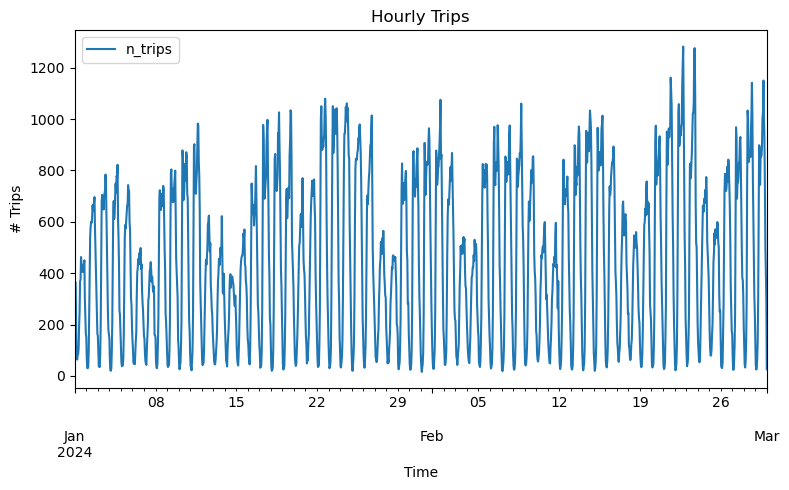

In [ ]:
hourly.plot(x="ts_hr", y="n_trips", title="Hourly Trips")
plt.xlabel("Time")
plt.ylabel("# Trips")
plt.tight_layout()
plt.show()

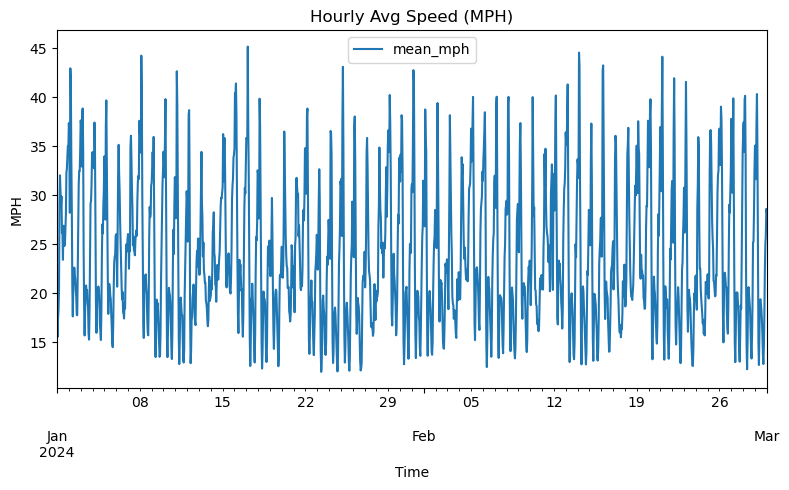

In [ ]:
hourly.plot(x="ts_hr", y="mean_mph", title="Hourly Avg Speed (MPH)")
plt.xlabel("Time"); plt.ylabel("MPH")
plt.tight_layout(); plt.show()

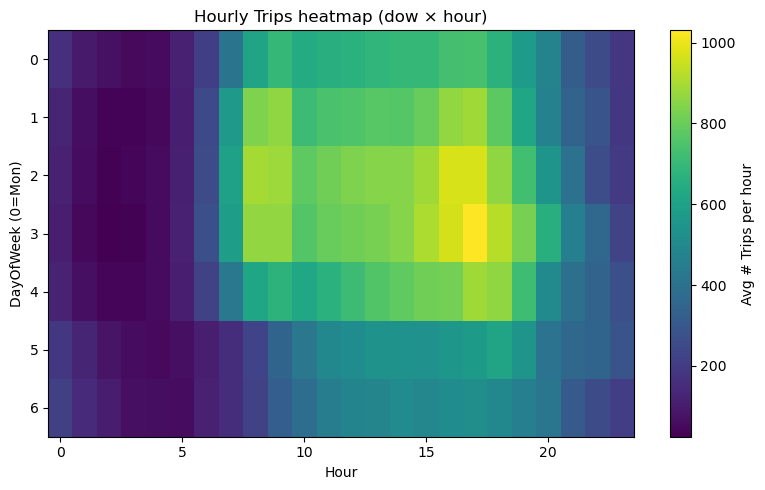

In [ ]:
hourly["dow"]  = hourly["ts_hr"].dt.dayofweek  # 0=Mon
hourly["hour"] = hourly["ts_hr"].dt.hour

pv_hr = (hourly
         .groupby(["dow","hour"])
         .agg(n_trips=("n_trips","mean"),
              fare_per_mile=("mean_fare_per_mile","mean"),
              mph=("mean_mph","mean"))
         .reset_index())

mat = pv_hr.pivot(index="dow", columns="hour", values="n_trips").fillna(0)

plt.imshow(mat, aspect="auto")
plt.title("Hourly Trips heatmap (dow × hour)")
plt.xlabel("Hour"); plt.ylabel("DayOfWeek (0=Mon)")
plt.colorbar(label="Avg # Trips per hour")
plt.tight_layout(); plt.show()

In [ ]:
df["is_weekday"] = df["dow"].between(0, 4).astype(int)
df["rush_hour"] = (
    df["is_weekday"].eq(1) &
    (
        df["hour"].between(7, 9) |
        df["hour"].between(16, 18)
    )
).astype(int)

df["rush_hour"].value_counts(normalize=True)

rush_hour
0    0.685874
1    0.314126
Name: proportion, dtype: float64

In [ ]:
def is_ord(lat, lon):
    return (lat.between(41.96, 42.01)) & (lon.between(-87.95, -87.85))

def is_mdw(lat, lon):
    return (lat.between(41.76, 41.81)) & (lon.between(-87.78, -87.71))

pickup_ord = is_ord(df["pickup_ct_lat"], df["pickup_ct_lon"])
dropoff_ord = is_ord(df["dropoff_ct_lat"], df["dropoff_ct_lon"])
pickup_mdw = is_mdw(df["pickup_ct_lat"], df["pickup_ct_lon"])
dropoff_mdw = is_mdw(df["dropoff_ct_lat"], df["dropoff_ct_lon"])

df["airport_trip"] = (
    pickup_ord | dropoff_ord | pickup_mdw | dropoff_mdw
).astype(int)

df["airport_trip"].value_counts(normalize=True)

airport_trip
0    0.730375
1    0.269625
Name: proportion, dtype: float64

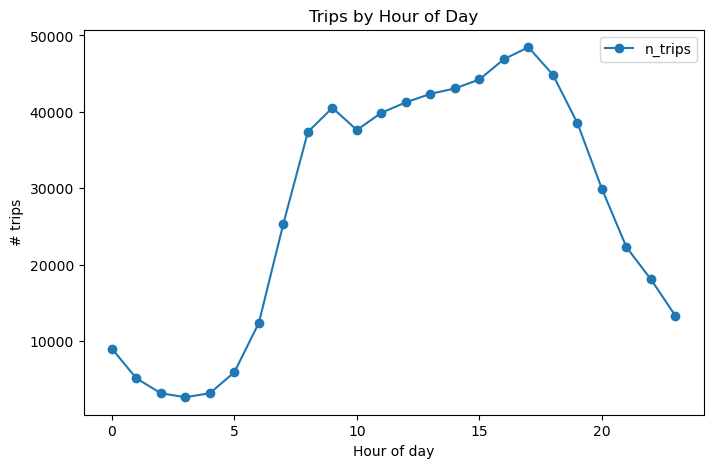

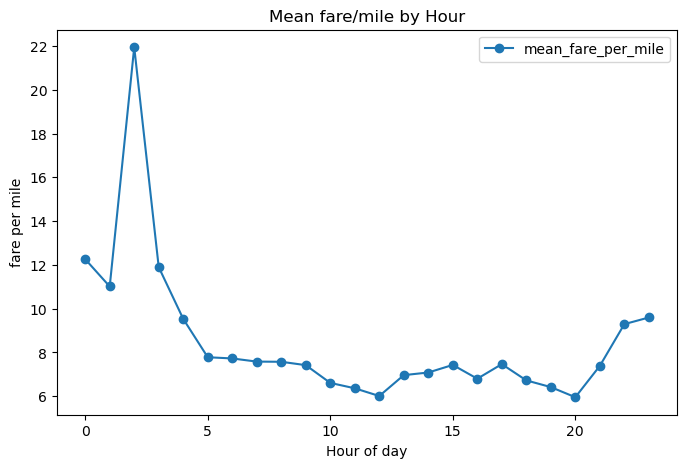

In [ ]:
hourly_trip = (df.groupby("hour")
                 .agg(n_trips=("Trip ID","size"),
                      mean_fare_per_mile=("fare_per_mile","mean"),
                      mean_mph=("mph","mean"))
                 .reset_index())

hourly_trip.plot(x="hour", y="n_trips", marker="o", title="Trips by Hour of Day")
plt.xlabel("Hour of day"); plt.ylabel("# trips")
plt.show()

hourly_trip.plot(x="hour", y="mean_fare_per_mile", marker="o",
                 title="Mean fare/mile by Hour")
plt.xlabel("Hour of day"); plt.ylabel("fare per mile")
plt.show()


          fare_per_mile                                     mph             \
                   mean    median        std   count       mean     median   
rush_hour                                                                    
0              7.292589  3.144219  96.557559  449565  21.827881  19.142857   
1              7.217651  4.245283  87.159556  205898  15.397737  12.284762   

                              
                 std   count  
rush_hour                     
0          12.343391  449565  
1           8.554254  205898  


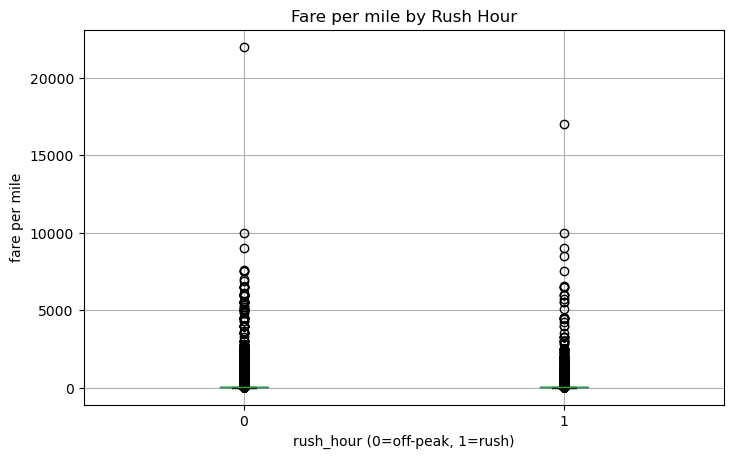

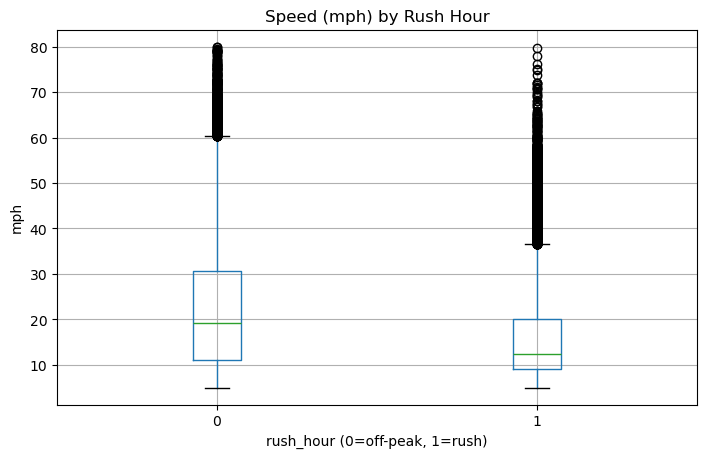

In [ ]:
summary_rush = (df.groupby("rush_hour")[["fare_per_mile","mph"]]
                  .agg(["mean","median","std","count"]))
print(summary_rush)

df.boxplot(column="fare_per_mile", by="rush_hour")
plt.title("Fare per mile by Rush Hour")
plt.suptitle("")
plt.xlabel("rush_hour (0=off-peak, 1=rush)")
plt.ylabel("fare per mile")
plt.show()

df.boxplot(column="mph", by="rush_hour")
plt.title("Speed (mph) by Rush Hour")
plt.suptitle("")
plt.xlabel("rush_hour (0=off-peak, 1=rush)")
plt.ylabel("mph")
plt.show()

99% quantile fare_per_mile: 20.588235294117645


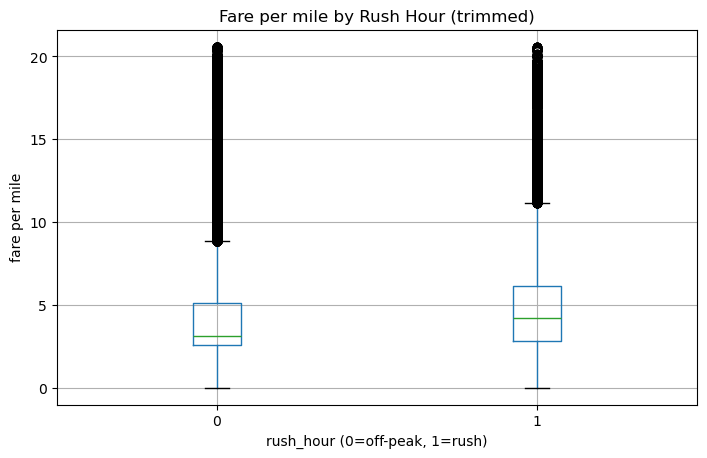

In [ ]:
df["fare_per_mile"].describe(percentiles=[.5, .9, .95, .99])
df["mph"].describe(percentiles=[.5, .9, .95, .99])

df = df[(df["mph"] > 0) & (df["mph"] <= 80)]

q99_fpm = df["fare_per_mile"].quantile(0.99)
print("99% quantile fare_per_mile:", q99_fpm)

cap_fpm = min(q99_fpm, 50)
df = df[df["fare_per_mile"] <= cap_fpm]

df.boxplot(column="fare_per_mile", by="rush_hour")
plt.title("Fare per mile by Rush Hour (trimmed)")
plt.suptitle("")
plt.xlabel("rush_hour (0=off-peak, 1=rush)")
plt.ylabel("fare per mile")
plt.show()


  rush_hour airport_trip fare_per_mile                mph        
                                  mean   count       mean   count
0         0            0      4.871711  309722  17.189103  309722
1         0            1      2.654574  135167  32.780588  135167
2         1            0      5.424989  163177  13.316235  163177
3         1            1      2.709805   40854  23.881009   40854


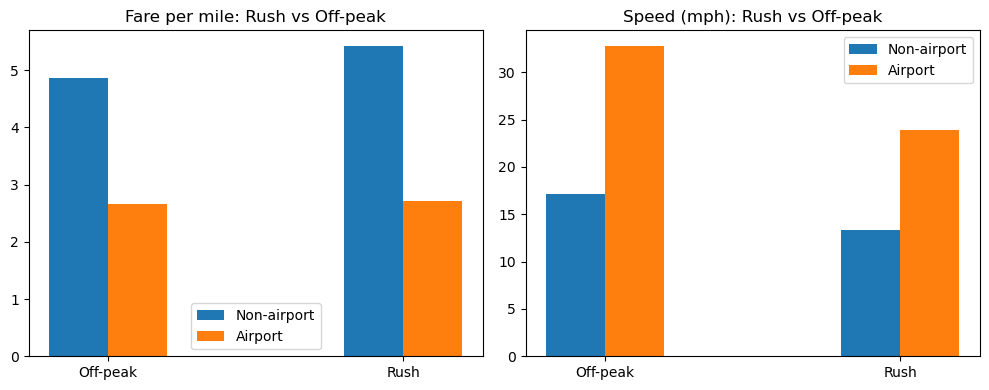

In [ ]:
tab = (df
       .groupby(["rush_hour","airport_trip"])[["fare_per_mile","mph"]]
       .agg(["mean","count"])
       .reset_index())
print(tab)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# fare per mile
for a in [0,1]:
    sub = df[df["airport_trip"]==a]
    label = "Non-airport" if a==0 else "Airport"
    means = sub.groupby("rush_hour")["fare_per_mile"].mean()
    ax[0].bar([0+0.2*a,1+0.2*a], means, width=0.2, label=label)
ax[0].set_xticks([0.1,1.1])
ax[0].set_xticklabels(["Off-peak","Rush"])
ax[0].set_title("Fare per mile: Rush vs Off-peak")
ax[0].legend()

# mph
for a in [0,1]:
    sub = df[df["airport_trip"]==a]
    label = "Non-airport" if a==0 else "Airport"
    means = sub.groupby("rush_hour")["mph"].mean()
    ax[1].bar([0+0.2*a,1+0.2*a], means, width=0.2, label=label)
ax[1].set_xticks([0.1,1.1])
ax[1].set_xticklabels(["Off-peak","Rush"])
ax[1].set_title("Speed (mph): Rush vs Off-peak")
ax[1].legend()

plt.tight_layout()
plt.show()


## Uplift RandomForest Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import auuc_score, qini_score
import matplotlib.pyplot as plt

Failed to import duecredit due to No module named 'duecredit'


In [ ]:
df = pd.get_dummies(df, columns=['company'], prefix='company')

In [ ]:
covariates = [
    'dow', 'hour', 'pickup_cluster', 'dropoff_cluster', 'miles', 'rush_hour',
    'euclidean_distance', 'distance_ratio',  # NEW FEATURES
    'company_312 Medallion Management Corp',
    'company_3556 - 36214 RC Andrews Cab', 'company_3591 - 63480 Chuks Cab',
    'company_4053 - 40193 Adwar H. Nikola', 'company_5 Star Taxi',
    'company_5167 - 71969 5167 Taxi Inc', 'company_6574 - Babylon Express Inc.',
    'company_Blue Ribbon Taxi Association',
    'company_Blue Ribbon Taxi Association Inc.',
    'company_Chicago City Taxi Association', 'company_Chicago Independents',
    'company_Chicago Taxicab', 'company_Choice Taxi Association',
    'company_Choice Taxi Association Inc', 'company_City Service',
    'company_Flash Cab', 'company_Globe Taxi',
    'company_Koam Taxi Association', 'company_Medallion Leasin',
    'company_Metro Jet Taxi A.',
    'company_Patriot Taxi Dba Peace Taxi Associat',
    'company_Petani Cab Corp', 'company_Setare Inc',
    'company_Star North Taxi Management Llc', 'company_Sun Taxi',
    'company_Tac - Checker Cab Dispatch',
    'company_Tac - Yellow Cab Association',
    'company_Taxi Affiliation Services',
    'company_Taxi Affiliation Services Llc - Yell',
    'company_Taxicab Insurance Agency Llc',
    'company_Taxicab Insurance Agency, LLC', 'company_Top Cab',
    'company_U Taxicab', 'company_2733 - 74600 Benny Jona'
]

treatment_col = 'airport_trip'
outcome_col = 'fare_per_mile'

X = df[covariates].copy()
treatment = df[treatment_col].copy()

y_cont = df[outcome_col].copy()
y = (y_cont > y_cont.median()).astype(int)

X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(
    X, treatment, y, test_size=0.3, random_state=42, stratify=treatment
)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [ ]:
# Convert treatment to string labels
treat_train_str = treat_train.astype(str)
treat_test_str = treat_test.astype(str)

model = UpliftRandomForestClassifier(
    n_estimators=800,
    max_depth=10,
    min_samples_leaf=50,
    random_state=42,
    control_name='0'
)

model.fit(
    X=X_train.values,
    treatment=treat_train_str.values,
    y=y_train.values
)

In [ ]:
uplift_scores = model.predict(X_test.values).ravel()

## Analysis

C:\Users\wxiny\AppData\Local\Temp\ipykernel_34148\1855047165.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auuc = np.trapz(uplift_curve, dx=1/n)
C:\Users\wxiny\AppData\Local\Temp\ipykernel_34148\1855047165.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  qini = np.trapz(qini_curve, dx=1/n)


AUUC Score: -0.3689
Qini Score: -11768.2852


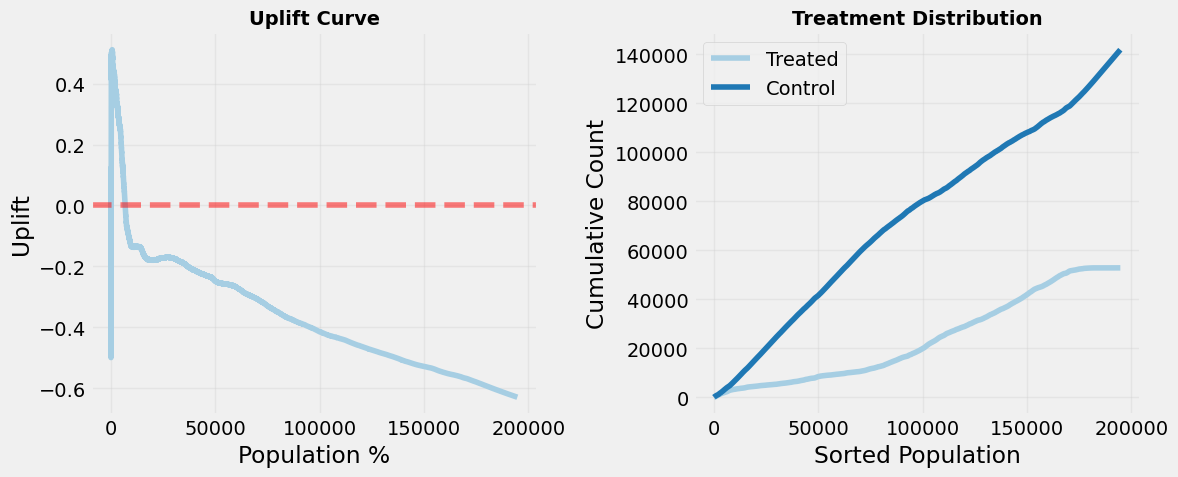

In [ ]:
from causalml.metrics import get_cumlift, get_cumgain
import matplotlib.pyplot as plt
import numpy as np

# 方法1: 手动计算 AUUC 和 Qini
def calculate_uplift_metrics(y_true, uplift_pred, treatment):
    sorted_idx = np.argsort(-uplift_pred)
    y_sorted = y_true[sorted_idx]
    t_sorted = treatment[sorted_idx]

    n = len(y_true)
    cum_treated = np.cumsum(t_sorted)
    cum_control = np.cumsum(1 - t_sorted)
    cum_y_treated = np.cumsum(y_sorted * t_sorted)
    cum_y_control = np.cumsum(y_sorted * (1 - t_sorted))

    cum_treated[cum_treated == 0] = 1
    cum_control[cum_control == 0] = 1

    uplift_curve = (cum_y_treated / cum_treated) - (cum_y_control / cum_control)

    auuc = np.trapz(uplift_curve, dx=1/n)

    qini_curve = cum_y_treated - cum_y_control * (cum_treated / cum_control)
    qini = np.trapz(qini_curve, dx=1/n)

    return auuc, qini, uplift_curve

y_arr = y_test.values.astype(int)
t_arr = treat_test.values.astype(int)
uplift_arr = uplift_scores.flatten()

auuc, qini, uplift_curve = calculate_uplift_metrics(y_arr, uplift_arr, t_arr)

print(f"AUUC Score: {auuc:.4f}")
print(f"Qini Score: {qini:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(uplift_curve)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title('Uplift Curve', fontsize=14, fontweight='bold')
plt.xlabel('Population %')
plt.ylabel('Uplift')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sorted_idx = np.argsort(-uplift_arr)
t_sorted = t_arr[sorted_idx]
cum_treated = np.cumsum(t_sorted)
cum_control = np.cumsum(1 - t_sorted)
plt.plot(cum_treated, label='Treated')
plt.plot(cum_control, label='Control')
plt.title('Treatment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sorted Population')
plt.ylabel('Cumulative Count')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

from sklearn.metrics import roc_auc_score

treated_mask = treat_test.values == 1
control_mask = treat_test.values == 0

if treated_mask.sum() > 0 and control_mask.sum() > 0:
    auc_treated = roc_auc_score(y_test.values[treated_mask],
                                 uplift_scores[treated_mask])
    auc_control = roc_auc_score(y_test.values[control_mask],
                                 uplift_scores[control_mask])

    uplift_auc = auc_treated - auc_control

    print(f"AUC Treated: {auc_treated:.4f}")
    print(f"AUC Control: {auc_control:.4f}")
    print(f"Uplift AUC: {uplift_auc:.4f}")

AUC Treated: 0.8122
AUC Control: 0.2182
Uplift AUC: 0.5939


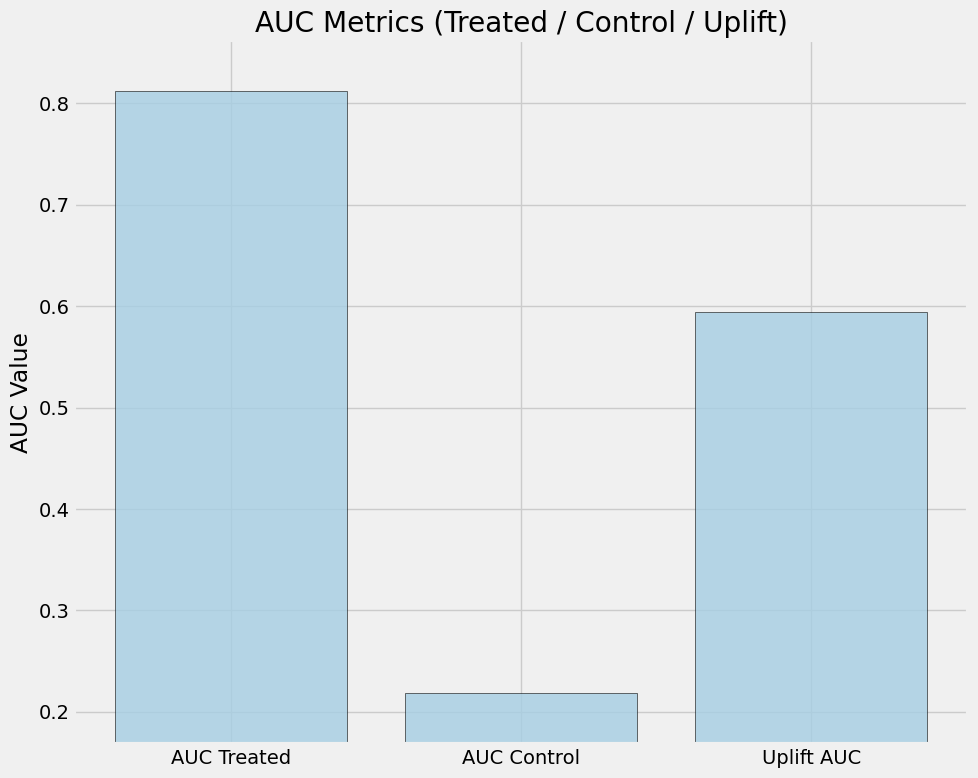

In [ ]:

plt.figure(figsize=(10, 8))
metrics = ['AUC Treated', 'AUC Control', 'Uplift AUC']
values = [auc_treated, auc_control, uplift_auc]

plt.bar(metrics, values, edgecolor='black', alpha=0.8)
plt.ylabel("AUC Value")
plt.title("AUC Metrics (Treated / Control / Uplift)")
plt.ylim(min(values) - 0.05, max(values) + 0.05)
plt.tight_layout()
plt.show()


In [ ]:
uplift_df = pd.DataFrame({
    'uplift_score': uplift_scores,
    'treatment': treat_test.values,
    'outcome': y_test.values
})


uplift_df['segment'] = pd.qcut(uplift_df['uplift_score'],
                                q=5,
                                labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print("=== Uplift Segments Analysis ===")
for segment in ['Very High', 'High', 'Medium', 'Low', 'Very Low']:
    seg_data = uplift_df[uplift_df['segment'] == segment]

    treated = seg_data[seg_data['treatment'] == 1]
    control = seg_data[seg_data['treatment'] == 0]

    treated_rate = treated['outcome'].mean() if len(treated) > 0 else 0
    control_rate = control['outcome'].mean() if len(control) > 0 else 0

    print(f"\n{segment} Uplift:")
    print(f"  High fare rate (Treated): {treated_rate:.2%}")
    print(f"  High fare rate (Control): {control_rate:.2%}")
    print(f"  Incremental effect: {treated_rate - control_rate:.2%}")
    print(f"  Sample size: {len(seg_data)}")

=== Uplift Segments Analysis ===

Very High Uplift:
  High fare rate (Treated): 19.14%
  High fare rate (Control): 40.06%
  Incremental effect: -20.93%
  Sample size: 38935

High Uplift:
  High fare rate (Treated): 6.77%
  High fare rate (Control): 54.79%
  Incremental effect: -48.02%
  Sample size: 38935

Medium Uplift:
  High fare rate (Treated): 1.61%
  High fare rate (Control): 65.71%
  Incremental effect: -64.10%
  Sample size: 38935

Low Uplift:
  High fare rate (Treated): 1.29%
  High fare rate (Control): 84.52%
  Incremental effect: -83.23%
  Sample size: 38934

Very Low Uplift:
  High fare rate (Treated): 1.19%
  High fare rate (Control): 97.64%
  Incremental effect: -96.45%
  Sample size: 38937


In [ ]:
import joblib

joblib.dump(model, "uplift_rf_model.pkl")
print("Model saved.")

Model saved.


=== Heterogeneous Treatment Effects by Decile ===
 decile  predicted_uplift  actual_ate  n_treated  n_control  treated_outcome_rate  control_outcome_rate
      5         -0.613256   -0.682586       9195      10277              0.012072              0.694658
     10         -0.291906   -0.179027       4426      15042              0.239268              0.418295
      9         -0.367628   -0.301981       1965      17502              0.083461              0.385442
      8         -0.421839   -0.375389       2942      16526              0.084976              0.460365
      4         -0.681695   -0.785347       7506      11962              0.010925              0.796272
      1         -0.892903   -0.987795        462      19008              0.000000              0.987795
      2         -0.800119   -0.945579       7531      11936              0.012615              0.958194
      6         -0.559164   -0.605615       6452      13011              0.021854              0.627469
      7       

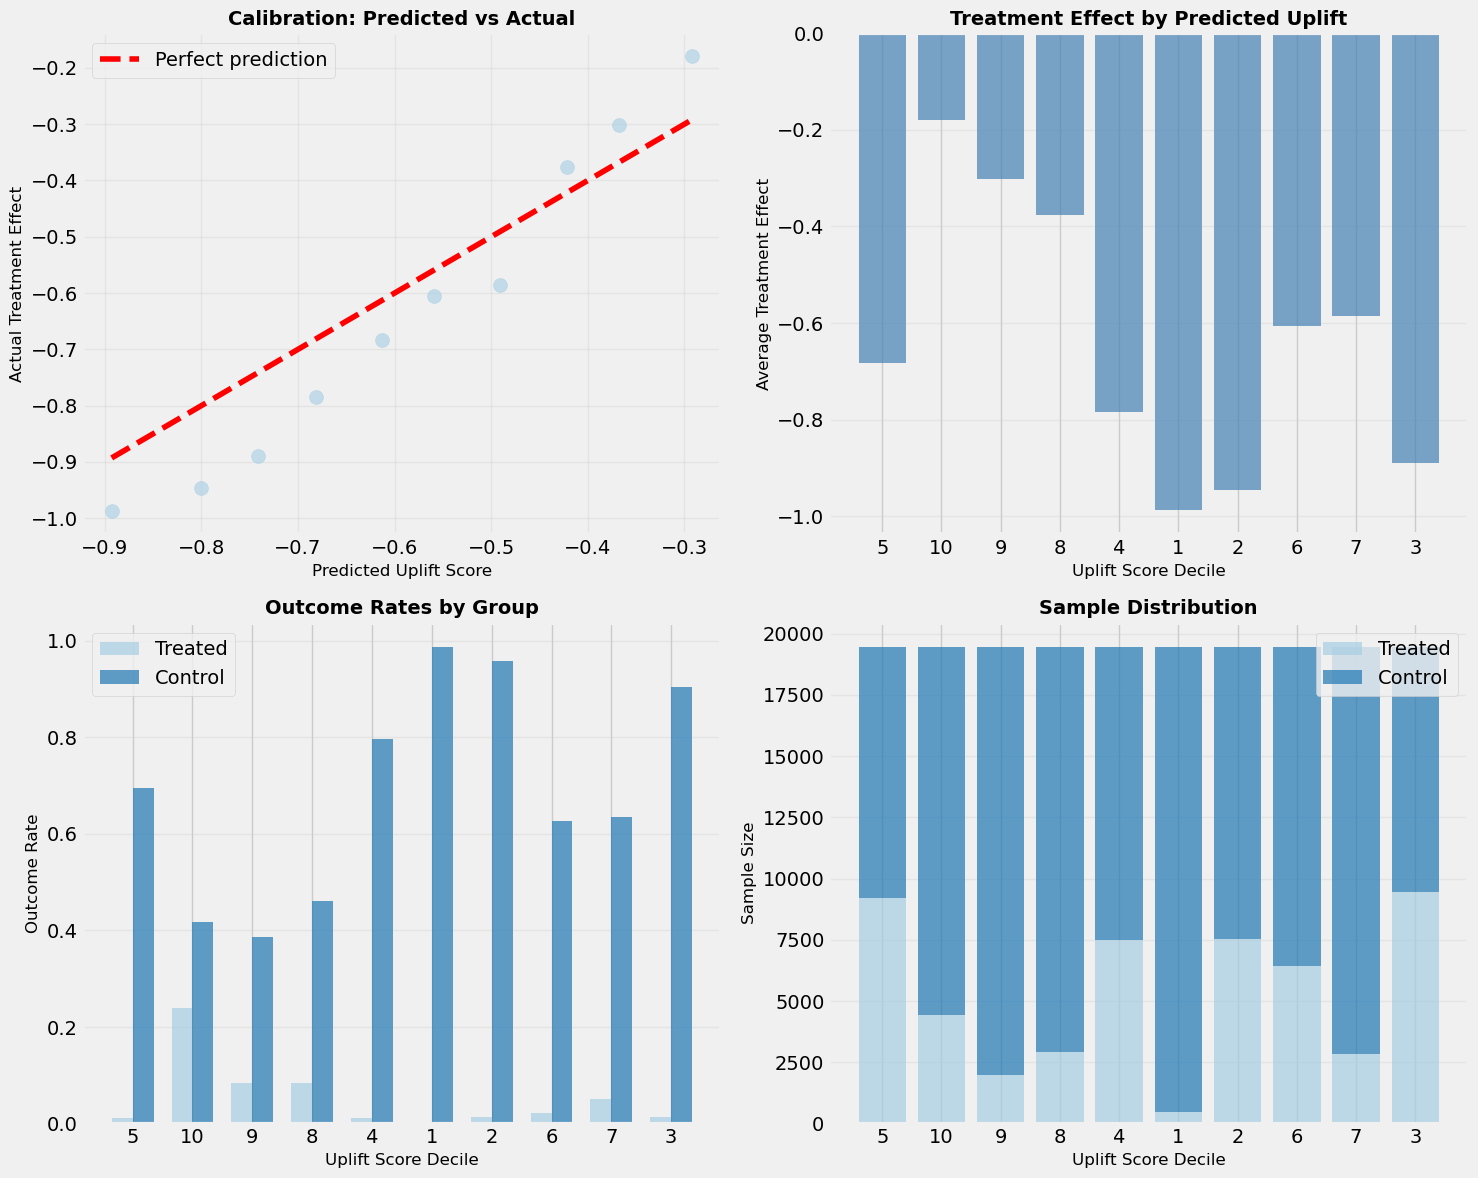

In [ ]:
def analyze_heterogeneous_effects(X_test, treat_test, y_test, uplift_scores):
    """
    分析treatment effect的异质性
    """
    results = pd.DataFrame({_
        'uplift_score': uplift_scores,
        'treatment': treat_test.values,
        'outcome': y_test.values
    })

    results['uplift_decile'] = pd.qcut(results['uplift_score'], q=10,
                                        labels=range(1, 11), duplicates='drop')

    effects = []
    for decile in results['uplift_decile'].unique():
        subset = results[results['uplift_decile'] == decile]

        treated = subset[subset['treatment'] == 1]
        control = subset[subset['treatment'] == 0]

        if len(treated) > 0 and len(control) > 0:
            ate = treated['outcome'].mean() - control['outcome'].mean()

            effects.append({
                'decile': decile,
                'predicted_uplift': subset['uplift_score'].mean(),
                'actual_ate': ate,
                'n_treated': len(treated),
                'n_control': len(control),
                'treated_outcome_rate': treated['outcome'].mean(),
                'control_outcome_rate': control['outcome'].mean()
            })

    effects_df = pd.DataFrame(effects)
    return effects_df

effects_df = analyze_heterogeneous_effects(X_test, treat_test, y_test, uplift_scores)
print("=== Heterogeneous Treatment Effects by Decile ===")
print(effects_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. predicted vs actual uplift
axes[0, 0].scatter(effects_df['predicted_uplift'], effects_df['actual_ate'], s=100, alpha=0.6)
axes[0, 0].plot([effects_df['predicted_uplift'].min(), effects_df['predicted_uplift'].max()],
                [effects_df['predicted_uplift'].min(), effects_df['predicted_uplift'].max()],
                'r--', label='Perfect prediction')
axes[0, 0].set_xlabel('Predicted Uplift Score', fontsize=12)
axes[0, 0].set_ylabel('Actual Treatment Effect', fontsize=12)
axes[0, 0].set_title('Calibration: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Treatment effect by decile
x_pos = range(len(effects_df))
axes[0, 1].bar(x_pos, effects_df['actual_ate'], alpha=0.7, color='steelblue')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Uplift Score Decile', fontsize=12)
axes[0, 1].set_ylabel('Average Treatment Effect', fontsize=12)
axes[0, 1].set_title('Treatment Effect by Predicted Uplift', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(effects_df['decile'])
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Outcome rates对比
width = 0.35
axes[1, 0].bar([x - width/2 for x in x_pos], effects_df['treated_outcome_rate'],
               width, label='Treated', alpha=0.7)
axes[1, 0].bar([x + width/2 for x in x_pos], effects_df['control_outcome_rate'],
               width, label='Control', alpha=0.7)
axes[1, 0].set_xlabel('Uplift Score Decile', fontsize=12)
axes[1, 0].set_ylabel('Outcome Rate', fontsize=12)
axes[1, 0].set_title('Outcome Rates by Group', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(effects_df['decile'])
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Sample size by decile
axes[1, 1].bar(x_pos, effects_df['n_treated'], alpha=0.7, label='Treated')
axes[1, 1].bar(x_pos, effects_df['n_control'], alpha=0.7, bottom=effects_df['n_treated'],
               label='Control')
axes[1, 1].set_xlabel('Uplift Score Decile', fontsize=12)
axes[1, 1].set_ylabel('Sample Size', fontsize=12)
axes[1, 1].set_title('Sample Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(effects_df['decile'])
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

UPLIFT MODEL COMPREHENSIVE ANALYSIS REPORT

1. MODEL INFORMATION
--------------------------------------------------------------------------------
   Model Type: UpliftRandomForestClassifier
   Test Set Size: 194,676
   Treated: 52,806 (27.1%)
   Control: 141,870 (72.9%)


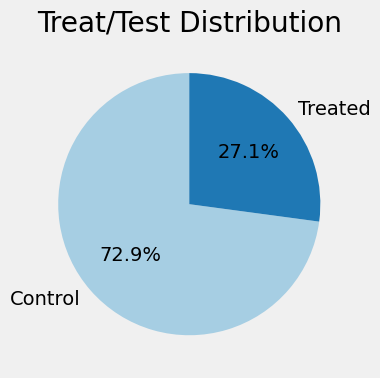


2. OVERALL TREATMENT EFFECT
--------------------------------------------------------------------------------
   Treated Outcome Rate: 0.0413
   Control Outcome Rate: 0.6715
   Average Treatment Effect (ATE): -0.6302


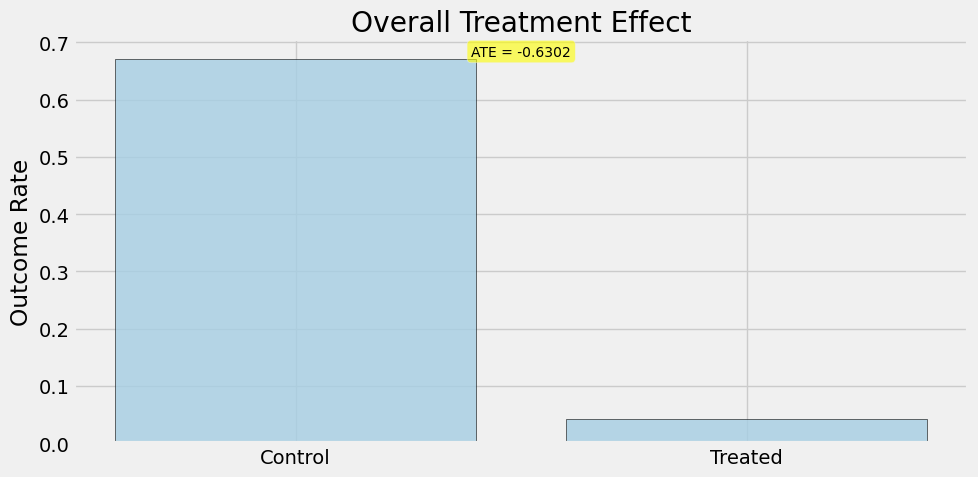


3. UPLIFT SCORE DISTRIBUTION
--------------------------------------------------------------------------------
   Mean: -0.5861
   Std: 0.1873
   Min: -0.9634
   25%: -0.7412
   50%: -0.5882
   75%: -0.4222
   Max: -0.0695


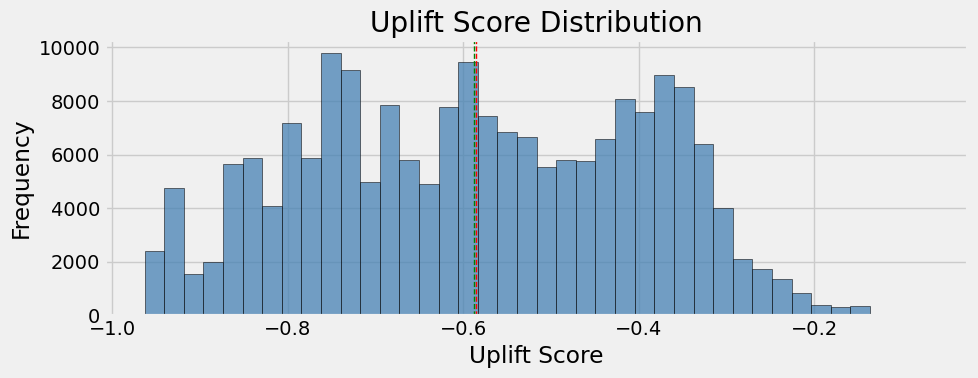


4. HIGH UPLIFT SEGMENT (Top 20%)
--------------------------------------------------------------------------------
   Treated Outcome Rate: 0.1914
   Control Outcome Rate: 0.4006
   Treatment Effect: -0.2093
   Lift over Overall ATE: -66.8%

5. TOP 10 FEATURE IMPORTANCES
--------------------------------------------------------------------------------
   pickup_cluster                          : 0.4390
   dropoff_cluster                         : 0.2526
   miles                                   : 0.1136
   company_Flash Cab                       : 0.0836
   hour                                    : 0.0288
   company_Taxicab Insurance Agency Llc    : 0.0249
   company_Chicago Independents            : 0.0123
   dow                                     : 0.0075
   company_Taxi Affiliation Services       : 0.0074
   company_Sun Taxi                        : 0.0066

END OF REPORT


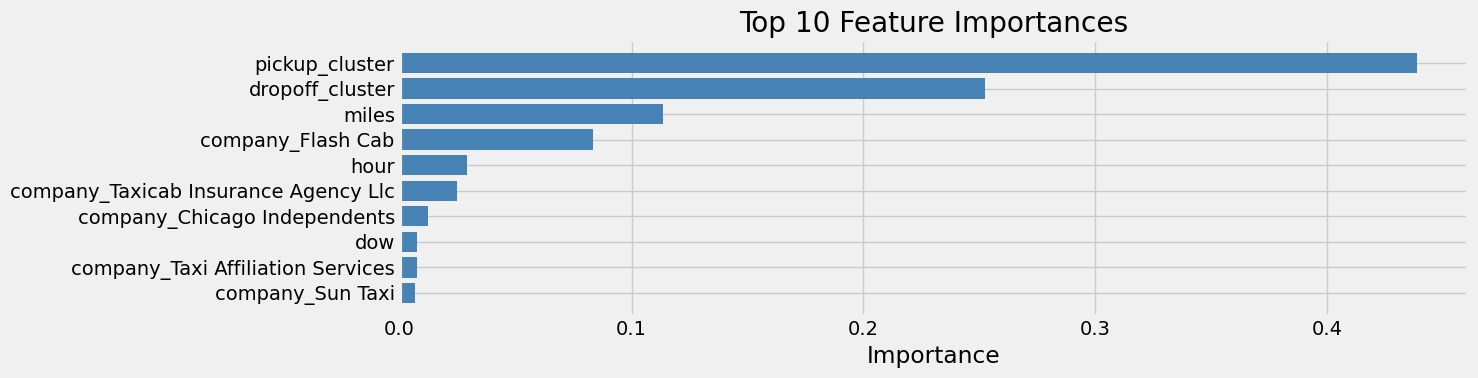

In [ ]:
def generate_uplift_summary(model, X_test, treat_test, y_test, uplift_scores,
                           feature_names):
    """
    Uplift Model Summary Report
    """
    print("="*80)
    print("UPLIFT MODEL COMPREHENSIVE ANALYSIS REPORT")
    print("="*80)

    # 1. Model Basic Information
    print("\n1. MODEL INFORMATION")
    print("-"*80)
    print(f"   Model Type: UpliftRandomForestClassifier")
    print(f"   Test Set Size: {len(y_test):,}")
    print(f"   Treated: {(treat_test==1).sum():,} ({(treat_test==1).mean()*100:.1f}%)")
    print(f"   Control: {(treat_test==0).sum():,} ({(treat_test==0).mean()*100:.1f}%)")
    plt.figure(figsize=(10, 4))
    counts = [(treat_test==0).sum(), (treat_test==1).sum()]
    plt.pie(
        counts,
        labels=['Control', 'Treated'],
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title("Treat/Test Distribution")
    plt.tight_layout()
    plt.show()

    # 2. Overall treatment effect
    print("\n2. OVERALL TREATMENT EFFECT")
    print("-"*80)
    treated_outcome = y_test[treat_test==1].mean()
    control_outcome = y_test[treat_test==0].mean()
    ate = treated_outcome - control_outcome
    print(f"   Treated Outcome Rate: {treated_outcome:.4f}")
    print(f"   Control Outcome Rate: {control_outcome:.4f}")
    print(f"   Average Treatment Effect (ATE): {ate:.4f}")
    # --- Simple bar plot for treatment effect ---
    plt.figure(figsize=(10, 5))
    plt.bar(['Control', 'Treated'],
            [control_outcome, treated_outcome],
            edgecolor='black',
            alpha=0.8)

    # annotate ATE
    plt.text(0.5,
             max(control_outcome, treated_outcome),
             f'ATE = {ate:.4f}',
             ha='center',
             va='bottom',
             fontsize=10,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

    plt.ylabel("Outcome Rate")
    plt.title("Overall Treatment Effect")
    plt.tight_layout()
    plt.show()


    # 3. Uplift score distribution
    print("\n3. UPLIFT SCORE DISTRIBUTION")
    print("-"*80)
    print(f"   Mean: {uplift_scores.mean():.4f}")
    print(f"   Std: {uplift_scores.std():.4f}")
    print(f"   Min: {uplift_scores.min():.4f}")
    print(f"   25%: {np.percentile(uplift_scores, 25):.4f}")
    print(f"   50%: {np.percentile(uplift_scores, 50):.4f}")
    print(f"   75%: {np.percentile(uplift_scores, 75):.4f}")
    print(f"   Max: {uplift_scores.max():.4f}")
    plt.figure(figsize=(10, 4))
    plt.hist(uplift_scores, bins=40, color='steelblue', alpha=0.75, edgecolor='black')
    plt.axvline(uplift_scores.mean(), color='red', linestyle='--', linewidth=1)
    plt.axvline(np.median(uplift_scores), color='green', linestyle='--', linewidth=1)
    plt.title("Uplift Score Distribution")
    plt.xlabel("Uplift Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


    # 4. Top uplift segment
    print("\n4. HIGH UPLIFT SEGMENT (Top 20%)")
    print("-"*80)
    top_20_idx = uplift_scores >= np.percentile(uplift_scores, 80)
    top_treated = y_test[(treat_test==1) & top_20_idx].mean()
    top_control = y_test[(treat_test==0) & top_20_idx].mean()
    print(f"   Treated Outcome Rate: {top_treated:.4f}")
    print(f"   Control Outcome Rate: {top_control:.4f}")
    print(f"   Treatment Effect: {top_treated - top_control:.4f}")
    print(f"   Lift over Overall ATE: {((top_treated - top_control) / ate - 1)*100:.1f}%")

    # 5. Feature importance
    print("\n5. TOP 10 FEATURE IMPORTANCES")
    print("-"*80)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    for idx, row in importance_df.iterrows():
        print(f"   {row['feature']:40s}: {row['importance']:.4f}")

    print("\n" + "="*80)
    print("END OF REPORT")
    print("="*80)
    plt.figure(figsize=(15, 4))
    plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
    plt.gca().invert_yaxis()
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


generate_uplift_summary(model, X_test, treat_test, y_test,
                       uplift_scores, covariates)